## Análisis exploratorio de datos

A continuación se presenta un primer análisis basado en los datos del Censo INE 2011, publicados en la página web del Instituto.

Además se utilizan varios conjuntos de datos disponibilizados en la web. Se realizó un pre-procesamiento para seleccionar variables relevantes, reduciendo el volúmen de datos y por tanto los requerimientos informáticos para su acceso. Las capas de información geográfica comprenden los de polígonos de departamentos y los puntos correspondientes a las localidades del INE, identificando las capitales departamentales en esta última capa.

También se cuenta con una matriz de distancias entre cada centro medio de población, calculada con la API Google Distance Matrix, que consta de distancias a pie por la red de caminería entre el centro medio de población de cada departamento, obteniendo una matriz de 342 valores ((19x19)-19).

Se prefirió usar el centro medio de población, en detrimento del centroide o la capital departamental. El centro medio de población se calcula transfiriendo el conteo de habitantes del segmento censal al centroide de dicho segmento, aplicando luego la siguiente fórmula:

$$
\overline{X}_w=\frac{\sum_{i=1}^{n}w_{i}X_{i}}{\sum_{i=1}^{n} w_{i}}
$$


$$
\overline{Y}_w=\frac{\sum_{i=1}^{n}w_{i}Y_{i}}{\sum_{i=1}^{n} w_{i}}
$$

dónde

$$w = peso$$

En este caso el "peso" (w) sería la población, en tanto que "x" e "y" son las coordenadas cartográficas de cada centroide. De esta forma se obtiene un par de coordenadas para cada departamento, que representa ese centro medio.

El uso del centro medio de población es más adecuado que usar el centroide en particular en aquellos departamentos en los cuales gran parte de la población se localiza concentrada en alguna ciudad lejana al centro del departamento. Los ejemplos paradigmáticos son Maldonado, Salto y Paysandú. En el caso contrario, es decir departamentos donde existe mayor dispesión espacial de la población, el centro medio de población se acerca más al centroide, en tanto que usar la capital sería no dar cuenta de la mencionada dispesión. Ejemplos de este caso son Colonia y Rocha. Es así que el centro medio de población proporciona una alternativa viable para contemplar estas dos categorías de departamentos.

El PBI departamental de toma de la información producida y publicada por OPP **(cita).**

In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tabulate
from operator import add

from shapely import wkt
from shapely.geometry import shape, LineString, Point
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))
    
# funciones desarrolladas
from functions.agrupar_dfs_censo import *
from functions.cargar_data import *

In [2]:
censo, pbi, md, deptos, deptos_sim, localidad, centro_pobl, capital = cargar_data_metod()

/home/guillermo/anaconda3/envs/tesis/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [3]:
censo.head()

,DPTO,LOC,SECC,SEGM,VIVID,TIPO_VIVIE,HOGCOD,HOGID,PERPH02,PERPA01,...,PERED02_4,PERED03_R,PERED03_1,PERED03_2,PERED04_R,PERED05_R,PERED06_R,CODIGO_CAR,PERED08,NIVELEDU_R
0,1,20,1,1,3,1,102001001000301,1,2,11,...,0,0,4,0,1,3,0,22101,1,4
1,1,20,1,1,3,1,102001001000301,1,2,1,...,0,0,2,0,2,2,0,11101,2,2
2,1,20,1,1,3,1,102001001000301,1,1,13,...,0,0,4,0,2,0,0,22101,1,4
3,1,20,1,1,3,1,102001001000301,1,2,12,...,0,0,0,0,0,0,0,101,0,0
4,1,20,1,1,5,1,102001001000501,1,2,1,...,0,11,0,0,0,5,4,55138,1,9


Dada la menor complejidad, se comienza por el análisis de los flujos entre departamentos.
La base de personas del Censo INE 2011 se filtra según el siguiente criterio:
- Variable "PERMI07" (lugar de residencia 5 años antes) con valores:
    - 2 = en otra localidad o paraje de este departamento
    - 3 = en otro departamento
    
Se excluyen habitantes de localidades rurales.

La tabla resultante contiene un departamento de origen, uno de destino y una cantidad de personas que declaran haber vivido antes en el departamento de "origen", habiendo sido relevadas en el departamento de "destino" al momento de la aplicación del formulario censal.

### El perfil de la migración interna

En el apartado 2.4, referido a los antecedentes del estudio de la migración interna en Uruguay, ya se puntualizaban algunas características de la población migrante interna:

- el perfil más joven y feminizado de quienes migran hacia Montevideo.

- el perfil de familias completas, integradas por parejas de entre 30 y 40 años con niños, de quienes migran desde Montevideo.

#### Genera tres data frames con:
- Migrantes de interior a Montevideo (A)
- Migrantes de Montevideo a interior (B)
- Migrantes entres deptos del interior (C)

In [4]:
# # genera dataframes por tipología
# def filter_df_mig(df, ver_dep_ori, var_dep_des):
#     "Corta DFs según origen y destino de la migración"
#     # destino Mvdeo.
#     a = df[df[var_dep_des] == 1].reset_index()
#     # origen Mvdeo. y destino no Mvdeo.
#     b = df[(df[ver_dep_ori] == 1) & (df[var_dep_des] != 1)].reset_index()
#     # origen y destino no Mvdeo.
#     c = df[(df[ver_dep_ori] != 1) & (df[var_dep_des] != 1)].reset_index()
    
#     return a, b, c

# # aplica función
# a, b, c = filter_df_mig(mgr_interdep, 'depto_origen', 'depto_destino')

# # enlista los tres DFs
# lista_dfs = [a, b, c]
# len(lista_dfs)

In [5]:
# # define columnas para filtrar
# cols = ['DPTO', 'LOC', 'SECC', 'SEGM', 'PERMI07', 'PERMI07_1',
#         'PERMI07_2', 'PERMI07_3', 'PERMI07_4']

# # filtra
# p_migr = censo.loc[(censo.PERMI07 == 2) | (censo.PERMI07 == 3), cols]

# # cambia DPTO a tipo entero
# p_migr.DPTO = p_migr.DPTO.astype(int)

# # print(p_migr.shape[0])

# # Hay 26.449 residentes en localidades rurales
# # print(p_migr[( p_migr.LOC == 900 )].shape[0])

# # identifica depto de residencia anterior


In [6]:
p_migr = filter_df_censo(censo)
p_migr.shape[0]

148759

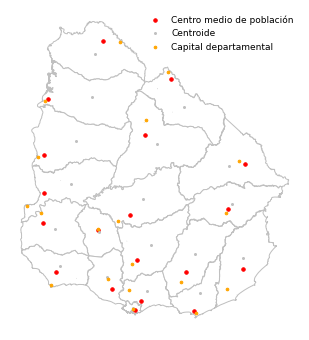

In [7]:
# plot de las capas de departamentos y localidades
f, ax = plt.subplots(1,figsize=(8,6))

# apaga ejes
plt.axis('off')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

# deptos
deptos.plot(color='w', edgecolor='silver',ax=ax)

# localidades
centro_pobl.plot(markersize=12, color = 'red', ax = ax, label='Centro medio de población')
deptos.geometry.centroid.plot(markersize=4, color = 'silver', ax = ax, label='Centroide')
capital.plot(markersize=7, color = 'orange', ax = ax, label='Capital departamental')

# título
# pl.title("Centroide, centro de población y capitales departamentales", size=10)

# referencias
plt.legend(fontsize=9, frameon=False)

metadatos_figs = {'Author': '''Guillermo D'Angelo''', 'Title': 'Mapa Centro de Población'}

# plt.savefig('mapas_graficas/centro_poblacion.pdf', bbox_inches='tight',
#             metadata = metadatos_figs )

In [8]:
# genera un sólo dataframe solo para deptos
flujos_deptos = p_migr[['depto_origen', 'depto_destino']]

flujos_deptos = flujos_deptos[flujos_deptos.depto_origen != flujos_deptos.depto_destino]

flujos_deptos['personas_mig'] = 1

# agrupa y cuenta
grupo = flujos_deptos.groupby(by=['depto_origen', 'depto_destino']).sum()

print('Cantidad de díadas ', grupo.shape[0])

grupo.head()

Cantidad de díadas  342


personas_mig
depto_origen depto_destino              
1            2                       914
             3                     33127
             4                      1387
             5                      2100
             6                       982

A continuación se presentan dichos datos en formato de matriz simétrica, refiriéndose a cada departamento con su código INE.

In [10]:
# genera tabla pivot con los flujos de departamento a departamento
matrix = pd.pivot_table(flujos_deptos,
                        index ='depto_origen',
                        columns='depto_destino',
                        fill_value=0,
                        aggfunc=sum,
                        margins=True,
                        margins_name='Total')
matrix

personas_mig                                                   \
depto_destino            1     2      3     4     5     6     7     8     9   
depto_origen                                                                  
1                        0   914  33127  1387  2100   982   378  1026   825   
2                     2395     0    536    20   167    33    21    40    15   
3                    11162    74      0   274   422   223    82   670   403   
4                     1805    15    435     0    63    67     5    73   131   
5                     2690    28    366    20     0    63    69    53    19   
6                     1610    32    466    64    70     0   149   404    67   
7                      735     2    162    13    86    90     0    76     5   
8                     1420    13    892    37   107   307    84     0   163   
9                     1264     7    446    64    39    29    17   138     0   
10                    2333    46    862   208   196    75    58   121   407   
11                    2096    75    434    35   151    55    29    57    37   
12                    1219    30    316    20   176    54    77    27    15   
13                    2390   102    584   162    77    50    22    63    49   
14                    1435     8    407    59    49    18     7    45   130   
15                    2481   380    543    18   134    14    20    48    20   
16                    1852    15    689    31   452    59   122   252    44   
17                    1922     9    293    12  1053    57    90    40    33   
18                    2611    50    596   168    79   304    79    92    50   
19                    1024    10    259   409    41    91     2    58   172   
Total                42444  1810  41413  3001  5462  2571  1311  3283  2585   

                                                                            \
depto_destino     10    11    12    13    14    15    16    17    18    19   
depto_origen                                                                 
1               3914  1075   886  1665  1266  1547  4209  1173  1421   760   
2                472   200    57   146    47   794    92    24   100     5   
3               1345   148   154   320   360   159   908   154   251   124   
4                810    61    41   145    95    19    49    34   135   476   
5                309    71    88    34    35    68   269   513    34    23   
6                198    59    62    42    61    28   124    32   212    77   
7                 79    30    36    10    13    17   116    85    29    14   
8                310    47    30    46    62    19   321    51    68    64   
9                936    28    11    25   150    15    45    11    45   221   
10                 0    95    95   117   535    98   131   110    71   259   
11               420     0   640    66    50   480   116    98   229    25   
12               223   516     0    54    48   133   107   270    89     9   
13               227   143    36     0    46   120    99    25   546    57   
14               952    32    30    17     0    29    45    18    21   162   
15               484   564   161    97    38     0    99    75   166     8   
16               230    59    55    32    47    30     0   112    53    23   
17               335   181   372    18    46    98   147     0    41    16   
18               363   261   134   421    35   174    88    72     0    32   
19               776    16    16    23   174    13    28    25    38     0   
Total          12383  3586  2904  3278  3108  3841  6993  2882  3549  2355   

                       
depto_destino   Total  
depto_origen           
1               58655  
2                5164  
3               17233  
4                4459  
5                4752  
6                3757  
7                1598  
8                4041  
9                3491  
10               5817  
11               5093  
12               3383  
13               4798  
14               

In [11]:
# # guarda en csv
# matrix = pd.pivot_table(flujos_deptos,
#                         index ='depto_origen',
#                         columns='depto_destino',
#                         fill_value=0,
#                         aggfunc=sum,
#                         margins=False)

# matrix.to_csv('tablas/matriz_deptos.csv', header=True)

In [12]:
# lista de nombres deptos para generar tabla en latex
nomdep = ['Mvdeo.', 'Artigas', 'Can.', 'C. Largo', 'Colonia', 'Durazno',
          'Flores', 'Florida', 'Lavalleja','Maldonado', 'Paysandú', 'R. Negro', 'Rivera',
          'Rocha', 'Salto', 'San José', 'Soriano', 'Tacuarembó', 'T. y Tres']

coddep = np.arange(1, 20, 1).tolist()

# guarda tabla en latex
# cabecera = datos_dpto.sort_values('DPTO')['NOMBRE'].to_list()
# cabecera.append('Total')

matrix_tex = matrix
matrix_tex.rename(index=dict(zip(coddep, nomdep)), inplace=True)

# setea ancho de columnas
ancho = 'p{0.7cm}'
colformato='l' + ancho * 20

matrix_tex.to_latex(buf= "tablas/matriz_orig_dest.tex", bold_rows=False,
                    column_format = colformato,
                    caption= 'Matriz de movimientos entre departamentos (Censo INE 2011).')

Se contruye un conjunto de datos que contiene la siguiente información para cada díada de departamentos:
- Los datos son los totales de personas que declaran haber vivido antes en el departamento de origen
- La población total en origen y destino
- El PBI en el departamento de destino y el logaritmo de dicho valor
- La distancia entre cada centro medio de población y el logaritmo de dicho valor

In [13]:
# unimos todo en un dataframe de díadas
df_agrupado = grupo.reset_index()

# agrega codigo único
df_agrupado.insert(0, 'cod', (df_agrupado['depto_origen'].astype(str)
                   + df_agrupado['depto_destino'].astype(str).str.zfill(2)).astype(int))

# recupera datos de otros dataframes
cols = ['DPTO', 'NOMBRE', 'miles_de_pesos', 'poblacion']
merge1 = pd.merge(df_agrupado, datos_dpto[cols],left_on='depto_origen', right_on='DPTO')
merge2 = pd.merge(merge1, datos_dpto[cols], left_on='depto_destino', right_on='DPTO')
merge3 = pd.merge(merge2, md[['cod', 'distancia']], on='cod')
datos_diadas = merge3.drop(['DPTO_x', 'DPTO_y'], axis=1)

# borra productos intermedios
del(merge1, merge2, merge3)

# renombra columnas
dict_rename = {'NOMBRE_x': 'nom_depto_orig', 'NOMBRE_y': 'nom_depto_des',
               'miles_de_pesos_x': 'pbi_origen', 'miles_de_pesos_y': 'pbi_destino',
               'distancia': 'dist', 'poblacion_x': 'pob_origen',
               'poblacion_y': 'pob_destino'}

datos_diadas.rename(columns=dict_rename, inplace=True)

# incorporamos el logaritmo del PBI departamental en destino
datos_diadas = datos_diadas.assign(log_pbi_destino = lambda x: np.log(x['pbi_destino']))

# incorporamos el logaritmo de las distancias entre díadas
datos_diadas = datos_diadas.assign(log_dist = lambda x: np.log(x['dist']))

# reordena variables
order = ['cod', 'depto_origen', 'nom_depto_orig',
         'depto_destino', 'nom_depto_des', 'personas_mig',
         'pbi_origen', 'pob_origen', 'pbi_destino', 'pob_destino',
         'dist', 'log_pbi_destino', 'log_dist']

datos_diadas = datos_diadas[order]
datos_diadas.head()

NameError: name 'datos_dpto' is not defined

In [ ]:
# guarda
datos_diadas.to_csv('tablas/datos_diadas_2011.csv')

In [ ]:
# define función para hacer lineas a partir de códigos origen-destino y una geografía conocida
# fuente: https://github.com/danlewis85/UCL_CASA_Urban_Simulation/blob/master/Unconstrained%20Spatial%20Interaction%20Models.ipynb

def _odline(orig, dest, geo, zonecode):
    return LineString([deptos[geo[zonecode] == orig].centroid.values[0], geo[geo[zonecode] == dest].centroid.values[0]])

# Makes a geodataframe of flows
def odflow(flowdata, origin, destination, flow_value, geo, zonecode):
    # First make all the lines
    lines = flowdata.apply(lambda x: _odline(x[origin], x[destination], geo, zonecode), axis=1)
    # Now get the series of flow values
    flows = flowdata[[flow_value, origin, destination]]
    # Now return a geodataframe
    return gpd.GeoDataFrame(flows, geometry=lines, crs = geo.crs)

# aplica función
flows = odflow(datos_diadas,'depto_origen', 'depto_destino', 'personas_mig', deptos,'cod_ine')

# guarda como geopaquete
flows.to_file("capas/mig_recientes_2011.gpkg", layer='flujos', driver="GPKG")

In [ ]:
datos_diadas.depto_origen

In [ ]:
def odflow(flowdata, origin, destination, flow_value, geo, zonecode):
    # First make all the lines
    lines = flowdata.apply(lambda x: _odline(x[origin], x[destination], geo, zonecode), axis=1)
    # Now get the series of flow values
    flows = flowdata[[flow_value, origin, destination]]
    # Now return a geodataframe
    return gpd.GeoDataFrame(flows, geometry=lines, crs = geo.crs)

In [ ]:
# plot de flujos
f, ax = plt.subplots(1,figsize=(8,6))

# apaga ejes
plt.axis('off')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

# capa de departamentos
deptos.plot(color='w', edgecolor='silver' ,ax=ax)

# máximo de flujos para escalado
maxflow = float(max(flows['personas_mig']))

# título
# pl.title("Representación gráfica de las migraciones recientes", size=10)

# plotea flows, calcula ancha de línea con una función sobre 'personas_mig'
flows.plot(linewidth = flows.apply(lambda x: (x['personas_mig']/maxflow)*10, axis=1),
           color = 'red',ax=ax, label='Flujos entre departamentos', alpha=0.5)

ax.set_aspect('equal')

# referencias
plt.legend(fontsize=9)

plt.savefig('mapas_graficas/links_depto.pdf', bbox_inches='tight',
            metadata = metadatos_figs )

In [ ]:
# Gráfico de flujos contra distancia
f, ax = plt.subplots(1, figsize=(10,6))

# plot de los puntos
ax.scatter(datos_diadas['dist'], datos_diadas['personas_mig'], marker='.', color='k')

# crea la linea roja
xvals = np.geomspace(0.0055, datos_diadas['dist'].max(), 1000)
yvals = np.power(xvals,-2.0)

# la agrega al plot
ax.plot(xvals, yvals, color='r')

# hide spines
[ax.spines[i].set_visible(False) for i in ['right', 'top', 'left', 'bottom']]

# etiquetas
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Distancia (m)")

# se ven dos outlyers claramente, deben ser Mvdeo y Canelones.

In [ ]:
# mismo gráfico sin Mvdeo.
sin_mvo = datos_diadas[(datos_diadas['depto_origen'] > 1) & (datos_diadas['depto_destino'] > 1)]

# Gráfico de flujos contra distancia
f, ax = plt.subplots(1, figsize=(10,6))

# plot de los puntos
ax.scatter(sin_mvo['dist'], sin_mvo['personas_mig'], marker='.', color='k')

# crea la linea roja
xvals = np.geomspace(0.025, sin_mvo['dist'].max(), 100)
yvals = np.power(xvals,-2.0)

# la agrega al plot
ax.plot(xvals, yvals, color='r')

# Etiquetas
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Distancia (m)")

In [ ]:
# gráfico de flujos contra población en el origen
f, ax = plt.subplots(1, figsize=(10,6))

# Plot data points
ax.scatter(datos_diadas['pob_origen'], datos_diadas['personas_mig'], marker='.', color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(datos_diadas['pob_origen'].min(), datos_diadas['pob_origen'].max(), 100)
yvals = np.power(xvals, 1.0)

# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-5000, datos_diadas['pob_origen'].max()*1.05)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Población en origen")

In [ ]:
# Plot de PBI en destino contra personas migrantes
f, ax = plt.subplots(1,figsize=(8,8))

# Plot data points
ax.scatter(datos_diadas['pbi_destino'], datos_diadas['personas_mig'], marker='.',color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(datos_diadas['pbi_destino'].min(), datos_diadas['pbi_destino'].max(), 100)
yvals = np.power(xvals,1.0)

# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-1000, datos_diadas['personas_mig'].max()*1.05)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("PBI en destino")

# Modelo restringido en origen

1 $$T_{ij} = A_{i}O_{i}W_{j}^{\alpha}d_{ij}^{-\beta}$$

dónde

2 $$O_{i} = \sum_{j}T_{ij}$$


3 $$A_{i} = \frac{1}{\sum_{j}W_{j}^{\alpha}d_{ij}^{-\beta}}$$



En el modelo restringido en origen $O_{i}$ no tiene parámetro dado que representa valores conocidos. $A_{i}$ es un factor de balance que refiere a cada origen $i$. Más específicamente $A_{i}$ permite que la suma de los valores estimados sea igual al total conocido $O_{i}$

El modelo es re-especificado como un modelo de regresión de Poisson. Se asume una vinculación

**We set about re-specifying the Production-Constrained model as a Poisson regression model in a similar way to how we did before. We need to take logs of the right-hand side of equation and assume that these are logarithmially linked to the Poisson distributed mean ($\lambda_{ij}$) of the $T_{ij}$ variable. Equation 1 (above) then becomes:**


4   $$ \lambda_{ij} = \exp( \mu_{i} + \alpha \ln W_{j} - \beta \ln d_{ij} )$$



In [14]:
# el depto_origen se cambio a tipo texto para que no sea tomada como variable numérica por la regresión
#  datos_diadas['depto_origen'] = datos_diadas.depto_origen.astype(str)

# respalda el objeto para usarlo en el otro modelo
dd=datos_diadas

NameError: name 'datos_diadas' is not defined

In [15]:
datos_diadas.head()

NameError: name 'datos_diadas' is not defined

Resultados de la aplicación del modelo restringido en origen:

In [ ]:
# Here we specify a model with no intercept (given by the -1 in the formula)
# In practice this means that all AiOis are estimated against an intercept of zero.
# Including the interval would mean setting the first borough in OrigNewCode to the intercept
# and interpreting all other categories in relation to that, which is less useful but would still work.
formula = "personas_mig ~ nom_depto_orig + log_pbi_destino + log_dist -1"
prodSim = smf.glm(formula=formula, data = datos_diadas, family = sm.families.Poisson()).fit()
prodSim.summary()

In [ ]:
prodSim_latex = prodSim.summary().as_latex()
f = open("tablas/prodSim.tex", "w")
f.write(prodSim_latex)
f.close()

De los resultados se desprende un parámetro $\alpha$ relacionado a la actractividad del destino de 0,8527.

El parámetro $\beta$ relativo al decaimiento por la distancia es de -0,7830

El coeficiente para cada origen es el valor registrado $A_{i}O_{i}$ para ese origen.

## Estimaciones del modelo restringido en origen

Los parámetros calculados se insertan en la ecuación nro. 4.

$$ \lambda_{ij} = \exp( \mu_{i} + 0,8527 ln W_{j}  + 0,7830 ln d_{ij} )$$


In [ ]:
# create some Oi and Dj columns in the dataframe and store row and column totals in them:
# First get the origin sums and rename the column created
O_i = datos_diadas.groupby('depto_origen')['personas_mig'].sum().to_frame()
O_i.rename(columns = {'personas_mig':'O_i'}, inplace=True)

# Now get the destination sums
D_j = datos_diadas.groupby('depto_destino')['personas_mig'].sum().to_frame()
D_j.rename(columns = {'personas_mig':'D_j'}, inplace=True)

# Merge in O_i
datos_diadas = datos_diadas.merge(O_i,left_on='depto_origen', right_index=True)

# Merge in D_j
datos_diadas = datos_diadas.merge(D_j,left_on='depto_destino', right_index=True)

datos_diadas.head()

In [ ]:
# recupera los parámetros del modelo
mu_i = prodSim.params.to_frame()

# elimina caractérres no numéricos para poder mergear
mu_i.rename(index = dict(zip(mu_i.index[0:-2].values, mu_i.index[0:-2].str.replace(r'[^ ABCDEFGHIJKLMNÑOPQRSTUVWXYZ]','').values)),
            inplace=True)

# renombre columna
mu_i.rename(columns = {0:'mu_i'}, inplace=True)

# merge
datos_diadas = datos_diadas.merge(mu_i, left_on='nom_depto_orig', right_index=True)

In [ ]:
mu_i

In [ ]:
# guarda parámetros estimados en objetos
alpha = prodSim.params[19]
beta  = prodSim.params[20]

print("alfa (log PBI destino)= " + str(alpha))
print("beta (log distancia)= " + str(beta))

In [ ]:
# genera estimación redondeada
# esta es la estimación del modelo de la ecuación 4, imputando los parámetro alfa y beta calculados
datos_diadas['prodsimest'] = np.round(np.exp(datos_diadas['mu_i']
                                             + alpha * datos_diadas['log_pbi_destino']
                                             + beta * datos_diadas['log_dist']))

In [ ]:
# matriz de flujos estimada por el modelo
datos_diadas['depto_origen'] = datos_diadas.depto_origen.astype(int)

matrix_prodsim = pd.pivot_table(datos_diadas,
                                values='prodsimest',
                                index ='depto_origen',
                                columns='depto_destino',
                                fill_value=0,
                                aggfunc=sum,
                                margins=True,
                                margins_name='Total')

matrix_prodsim.Total = matrix_prodsim.Total.astype(int)

matrix_prodsim

In [ ]:
matrix

In [ ]:
matrix_prodsim_tex = matrix_prodsim.rename(index=dict(zip(coddep, nomdep)))

matrix_prodsim_tex.to_latex(buf= "tablas/prodsim_matriz_orig_dest.tex", bold_rows=False,
                            column_format = colformato,  float_format="%.2f",
                            caption= 'Matriz de movimientos entre departamentos estimada mediante SIM restringido en origen.')

Se puede identificar la coincidencia de la matriz de los datos originales con la de los datos estimados en la columna de origen $O_{i}$, con leves diferencias producto del redondeo.

$$\sum_{j}T_{ij} = \sum_{j}\lambda_{ij} = O_{i}$$

In [ ]:
# bondad de ajuste

# define una función para calcular el R cuadrado
def calcR2(obs, est):
    return np.power(np.corrcoef(obs,est),2.0)[0][1]

# define una función para calcula el error medio cuadrático
def calcRMSE(obs,est):
    return np.sqrt((np.power((obs - est),2.0)).mean())

In [ ]:
printmd('**Bondad de ajuste del modelo restringido en origen**')

printmd("$R²$ = " + round(calcR2(datos_diadas['personas_mig'],datos_diadas['prodsimest']), 4).astype(str))

printmd("RMSE = " + round(calcRMSE(datos_diadas['personas_mig'],datos_diadas['prodsimest']), 4).astype(str))


# Modelo de doble restricción

5    $$ T_{ij} = A_{i}O_{i}B_{i}D_{j}d_{ij}^{-\beta }$$

dónde

6 $$O_{i} = \sum_{j}T_{ij}$$

7 $$D_{j} = \sum_{i}T_{ij}$$

8 $$A_{i} = \frac{1}{\sum_{j}B_{j}D_{j}d_{ij}^{-\beta}}$$

9 $$B_{j} = \frac{1}{\sum_{j}A_{i}O_{j}d_{ij}^{-\beta}}$$

La dificultad es que $A_{i}$ depende de $B_{j}$ y viceversa. Pero se puede arrivar a un valor para ambos factores fijando el valor de $B$ inicialmente como 1, y luego iterando refinando el valor de cada uno hasta que sea estable (converjan).

In [ ]:
# Modelo de restricción doble

# recupera los datos del respaldo
datos_diadas = dd
# formula = "personas_mig ~ nom_depto_orig + nom_depto_des + log_pbi_destino + log_dist -1"

# siguiendo a Dennett y la guía de R, cambiamos la fórmula, borrando el "-1" al final
# es decir que se mantiene la intersección

# The code below has changed a litte from the singly constrained models I have removed the ‘-1’
# which means that an intercept will appear in the model again. This is not because I want an
# intercept as it makes the origin and destination coefficients harder to interpret - reference categories
# zones will appear and the coefficients will need to be compared with the intercept - rather the ‘-1’ cheat
# for removing the intercept only works with one factor level - here we have two (origins and destinations).
# For full details and an explanation for alternative ways for dealing with this, please visit
# here - https://stats.stackexchange.com/questions/215779/removing-intercept-from-glm-for-multiple-factorial-predictors-only-works-for-fir - for ease, here we will just continue with the intercept.

formula = "personas_mig ~ nom_depto_orig + nom_depto_des + log_pbi_destino + log_dist"

doubSim = smf.glm(formula=formula, data = datos_diadas, family = sm.families.Poisson()).fit()
doubSim.summary()

In [ ]:
# guarda DF para enviar a Eugenia
datos_diadas.head()
datos_diadas.to_csv('tablas/datos_diadas.csv', index=False)

In [ ]:
doubSim_latex = doubSim.summary().as_latex()
f = open("tablas/doubSim.tex", "w")
f.write(doubSim_latex)
f.close()

In [ ]:
# recupera los valores estimados
datos_diadas['doubsim_ajustado'] = np.round(doubSim.predict())

datos_diadas['depto_origen'] = datos_diadas.depto_origen.astype(int)

# matriz de los valores estimados
matrix_doubsim = pd.pivot_table(datos_diadas,
                                values='doubsim_ajustado',
                                index ='depto_origen',
                                columns='depto_destino',
                                fill_value=0,
                                aggfunc=sum,
                                margins=True,
                                margins_name='Total')

matrix_doubsim.Total = matrix_doubsim.Total.astype(int)

matrix_doubsim

In [ ]:
matrix_doubsim_tex = matrix_doubsim.rename(index=dict(zip(coddep, nomdep)))

matrix_doubsim_tex.to_latex(buf = "tablas/doubsim_matriz_orig_dest.tex",
                            bold_rows = False,
                            column_format = colformato,
                            float_format ="%.2f",
                            caption = 'Matriz de movimientos entre departamentos estimada mediante SIM de doble restricción.')

In [ ]:
matrix

Se puede observar la igualdad de los valores originales $O_{i}$ y $D_{j}$, pero al igual que en el modelo de restricción en origen se producen leves direrencias que atrubuimos al redondeo.

In [ ]:
printmd('**Bondad de ajuste del modelo de doble restricción**')

printmd("$R²$ = " + round(calcR2(datos_diadas['personas_mig'],  datos_diadas['doubsim_ajustado']), 4).astype(str))

printmd("RMSE = " + round(calcRMSE(datos_diadas['personas_mig'],datos_diadas['doubsim_ajustado']), 4).astype(str))

El coeficiente de determinación $R²$ mejora en comparación con resultante del modelo restringido en origen.

In a departure from Dennett, I've rewritten the algorithm as a function, which can then be called subject to the required parameters. In order for it to work it requires the following things:

    pd - a pandas dataframe of origin-destination pairwise flows and associated data.
    orig_field - the name of the dataframe field in pd that uniquely labels origin zones.
    dest_field - the name of the dataframe field in pd that uniquely labels destination zones.
    Oi_field - the name of the dataframe field that stores total flows from a given origin $i$
    Dj_field - the name of the dataframe field that stores total flows to a given destination $j$
    cij_field - the name of the dataframe field that stores the pairwise cost (e.g. distance) between $i$ and $j$
    beta - a constant for the beta parameter you wish to use in the model
    cost_function - a string representing the cost function, either 'power' or 'exponential'
    Ainame - What you want to call the new field in pd that will hold $A&lt;/em&gt;{i}$ values, defaults to "Ai_new"
    Bjname - What you want to call the new field in pd that will hold $B&lt;/em&gt;{j}$ values, defaults to "Bj_new"
    converge - A threshold value at which a model can be said to have converged, the default of 0.001 seems to work fine.

NB Remember that we calculated $O_{i}$ and $D_{j}$ earlier, they are simply the total flows by either origin or destination.

In [ ]:
datos_diadas.head()

In [ ]:
# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field,
                               Oi_field, Dj_field, cij_field, beta, 
                               cost_function,
                               Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]
    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd

In [ ]:
# create some Oi and Dj columns in the dataframe and store row and column totals in them:
# First get the origin sums and rename the column created
O_i = datos_diadas.groupby('depto_origen')['personas_mig'].sum().to_frame()
O_i.rename(columns = {'personas_mig':'O_i'}, inplace=True)

# Now get the destination sums
D_j = datos_diadas.groupby('depto_destino')['personas_mig'].sum().to_frame()
D_j.rename(columns = {'personas_mig':'D_j'}, inplace=True)

# Merge in O_i
datos_diadas = datos_diadas.merge(O_i,left_on='depto_origen', right_index=True)

# Merge in D_j
datos_diadas = datos_diadas.merge(D_j,left_on='depto_destino', right_index=True)

datos_diadas.head()

In [ ]:
# recupera el beta del logaritmo de la distancia del modelo anterior
beta = doubSim.params[-1]
beta

In [ ]:
# recupera factores de balance
datos_diadas = balance_doubly_constrained(datos_diadas, 'nom_depto_orig', 'nom_depto_des', 'O_i', 'D_j', 'log_dist', beta, 
                                          'pow', Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001)

In [ ]:
datos_diadas.head()

In [ ]:
# Now predict the model again using the new Ai and Dj fields.
datos_diadas['SIM_est_pow'] = np.round(datos_diadas['O_i'] * datos_diadas['Ai_new'] * datos_diadas['D_j'] * datos_diadas['Bj_new'] * 
                                       np.exp(np.log(datos_diadas['log_dist'])*beta))


In [ ]:
# Check out the matrix
pd.pivot_table(datos_diadas, values='SIM_est_pow', index ='depto_origen',
               columns='depto_destino', fill_value=0, aggfunc=sum, margins=True)

In [ ]:
printmd('**Bondad de ajuste del modelo de doble restricción**')

printmd("$R²$ = " + round(calcR2(datos_diadas['personas_mig'],  datos_diadas['doubsim_ajustado']), 4).astype(str))

printmd("RMSE = " + round(calcRMSE(datos_diadas['personas_mig'],datos_diadas['doubsim_ajustado']), 4).astype(str))

In [ ]:
# jugar con modelación de distance decay
# jugar con distancia en lugar de logaritmo
# probar con algún modelo kitchen sink
# graficas y algún mapa
#!jupyter nbconvert --to markdown --no-input 02-metodologia.ipynb 

# graficar logaritmo de los flujos vs logaritmo de la distancia

# probar paquete SPInt taylor oshan

# ATENCIÓN!
# Another thing to note is that the example we used here had quite neat data. You will almost certainly run into problems if you have sparse data or predictors with 0s in them. If this happens, then you might need to either drop some rows in your data (if populated with 0s) or substitute 0s for very small numbers, much less than 1, but greater than 0 (this is because you can’t take the log of 0). Taylor Oshan's SpInt implementation in Python uses a special Poisson regression approach that better handles sparse data structures.


# modelar con binomial negativa

